In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import random
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime
from helperFunctions import createDataSet

In [2]:
""" 
Checking if finger prick, bolus shot and carb input were close to each other.
Useful datasets:
Ohio 2018:
575: Looks okay.
591: Could work with it.
The other data sets weren't that interesting.

Ohio 2020:
540: Not useful due to many missing carb inputs.
544: Nice data, took the fingerpricks, bolus shots and carb inputs seriously and can be seen very well in data.
552:
567: Lots of missing cbg values -> Hard to know what true cbg was.
584: fingerpricks, bolus shots and carb inputs are very sparse -> not helpful
596: Second half looks kind of alright.

Since the 544 data set had the most promising plots, will focus solely on this data set. 
"""

" \nChecking if finger prick, bolus shot and carb input were close to each other.\nUseful datasets:\nOhio 2018:\n575: Looks okay.\n591: Could work with it.\nThe other data sets weren't that interesting.\n\nOhio 2020:\n540: Not useful due to many missing carb inputs.\n544: Nice data, took the fingerpricks, bolus shots and carb inputs seriously and can be seen very well in data.\n552:\n567: Lots of missing cbg values -> Hard to know what true cbg was.\n584: fingerpricks, bolus shots and carb inputs are very sparse -> not helpful\n596: Second half looks kind of alright.\n\nSince the 544 data set had the most promising plots, will focus solely on this data set. \n"

['5minute_intervals_timestamp' 'missing_cbg' 'cbg' 'finger' 'basal' 'hr'
 'gsr' 'carbInput' 'bolus']


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_97212/1986774312.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


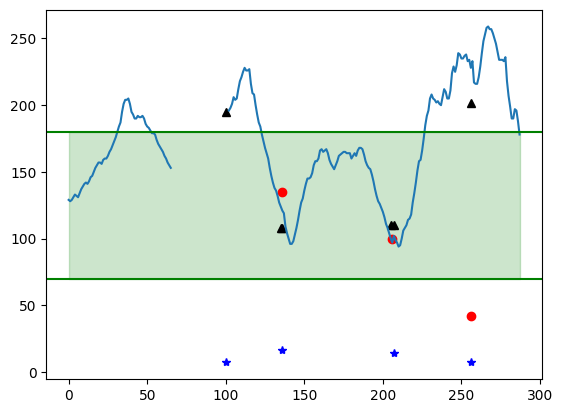

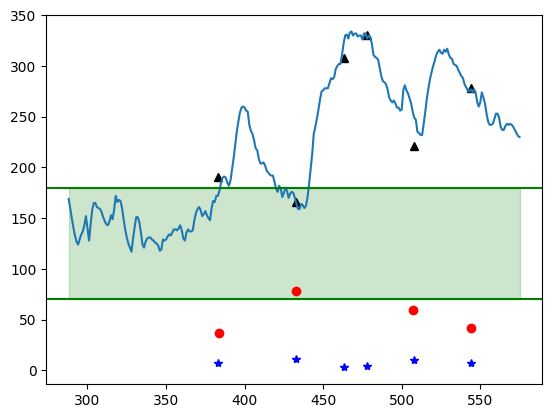

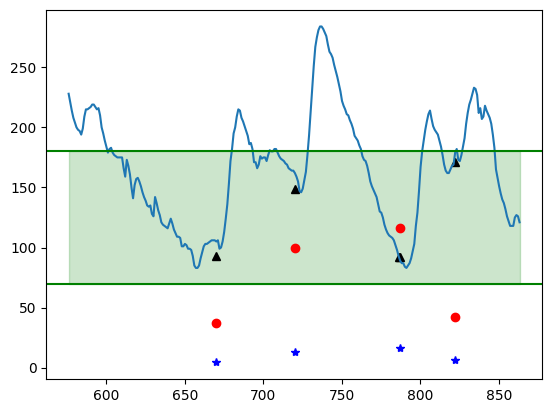

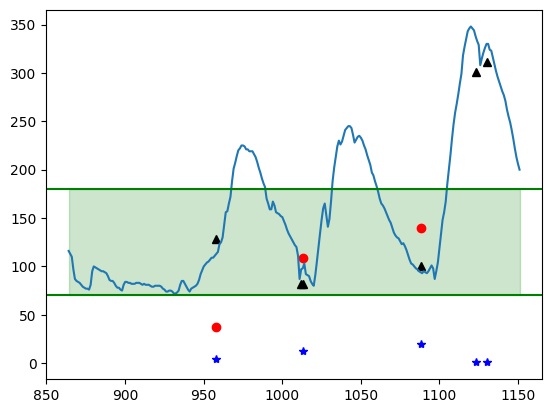

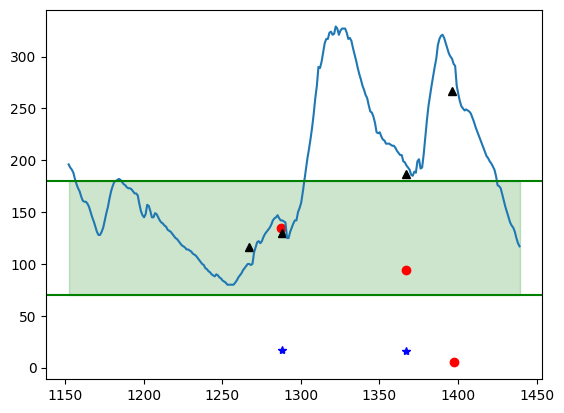

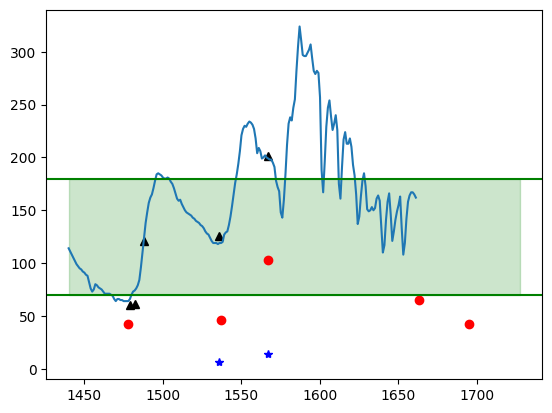

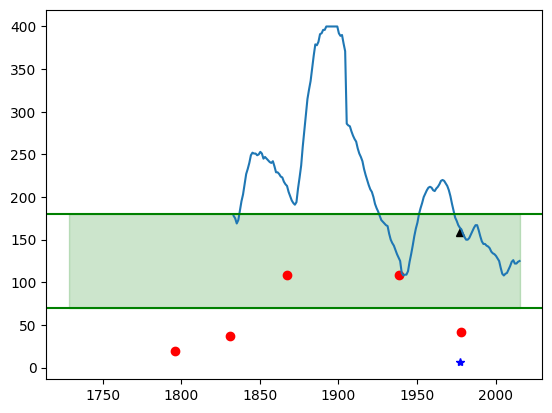

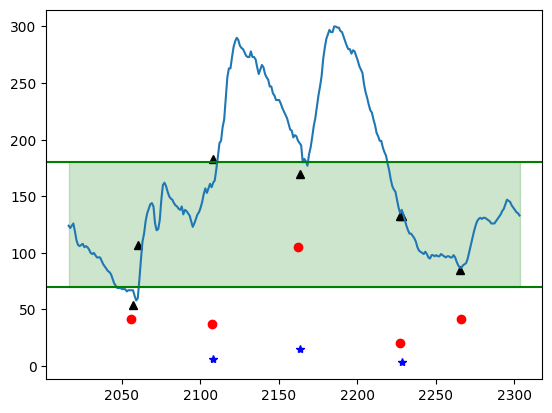

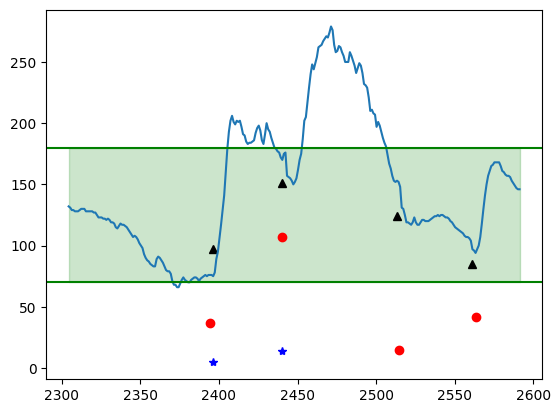

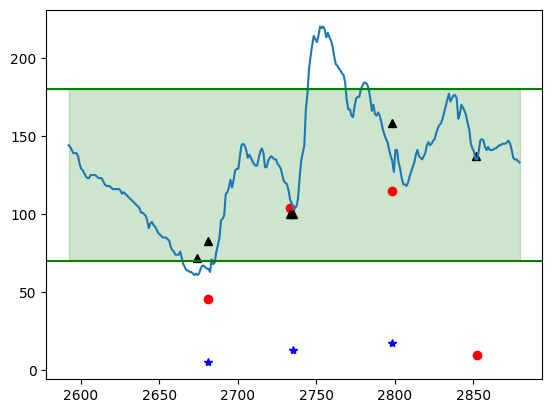

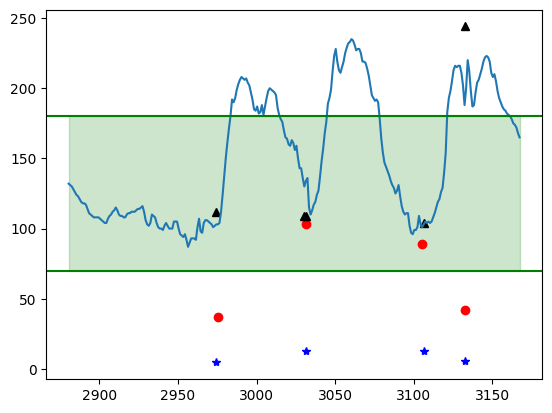

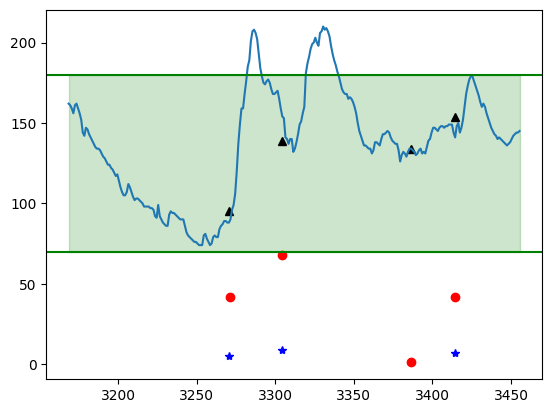

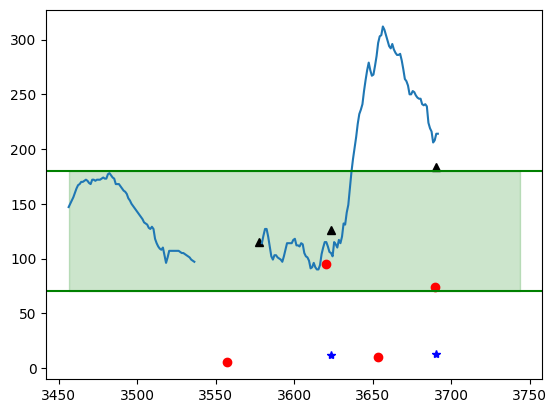

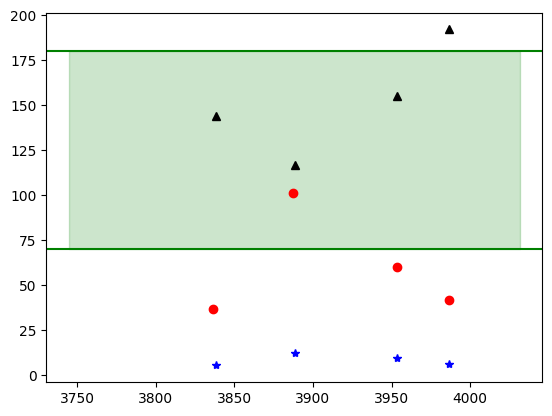

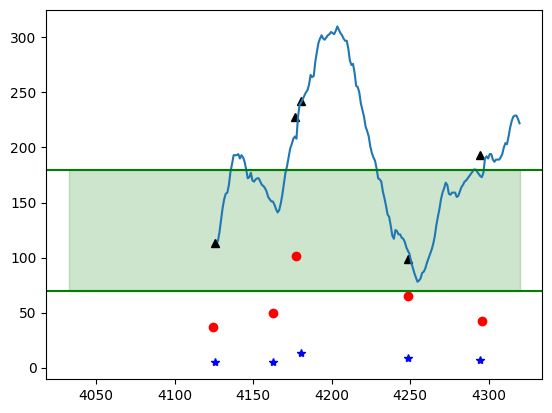

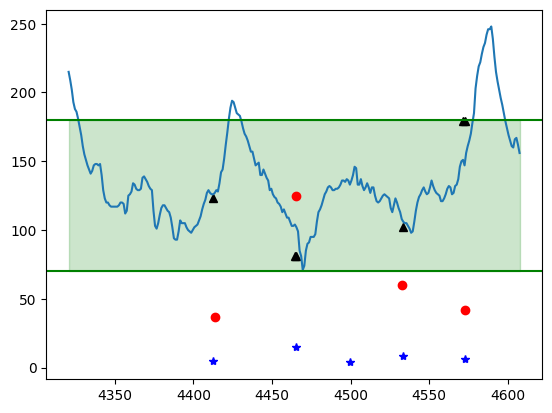

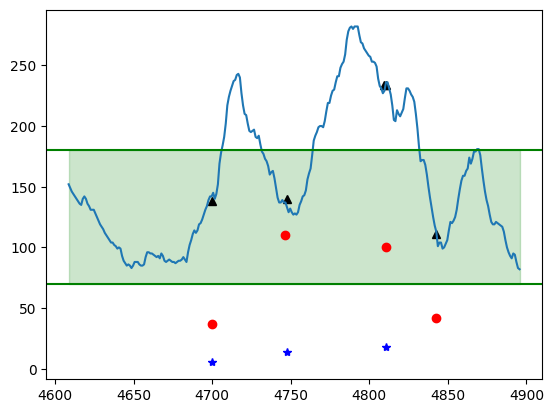

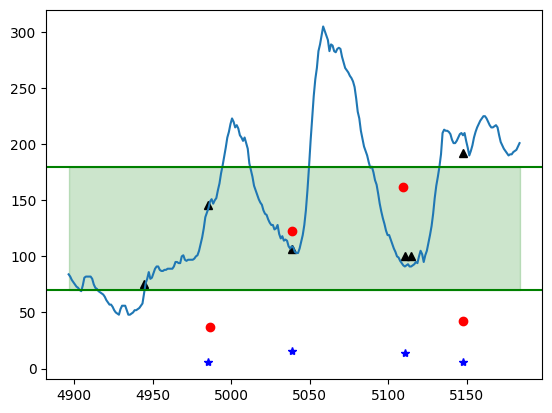

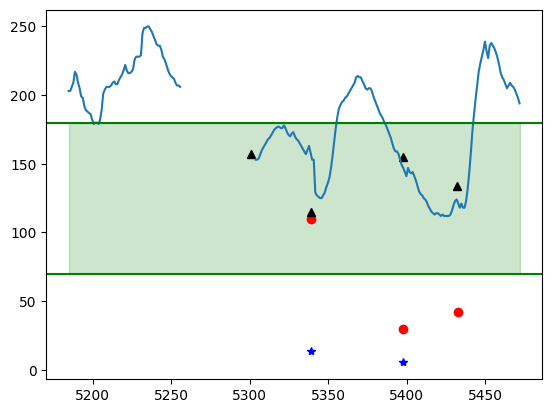

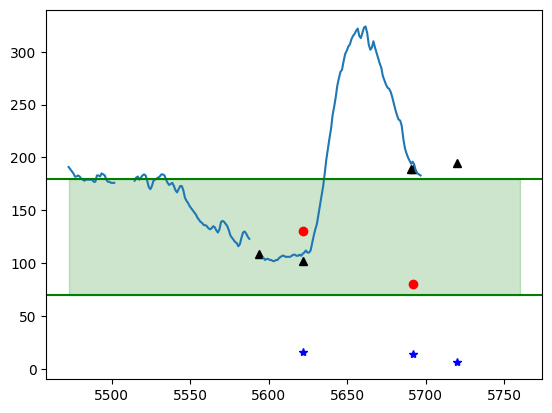

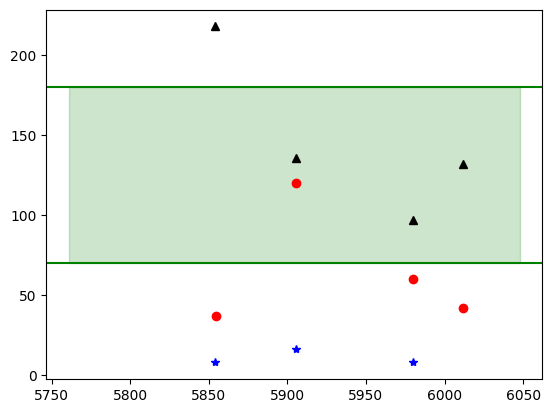

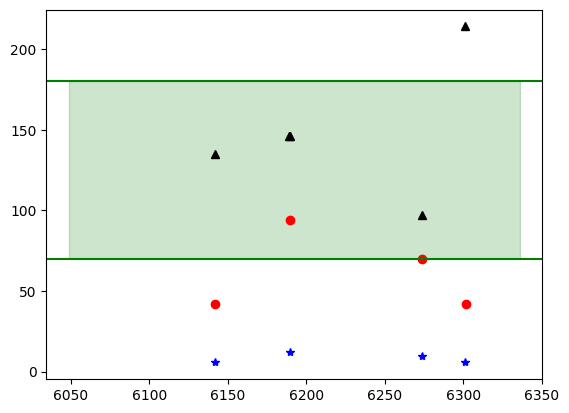

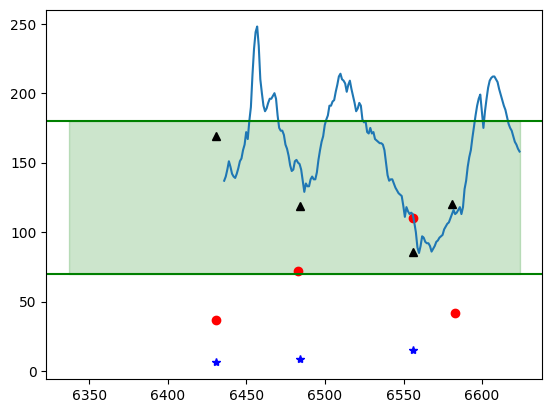

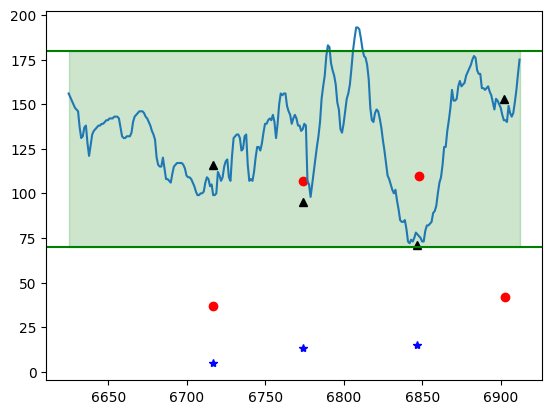

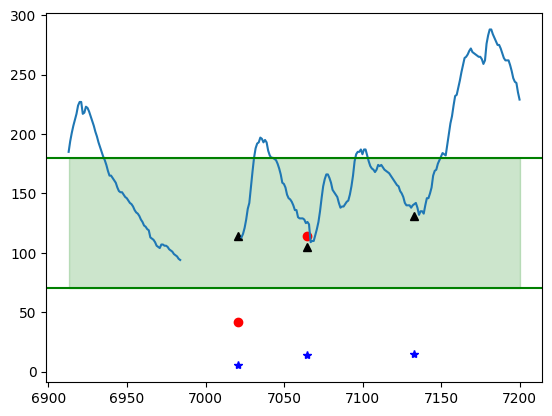

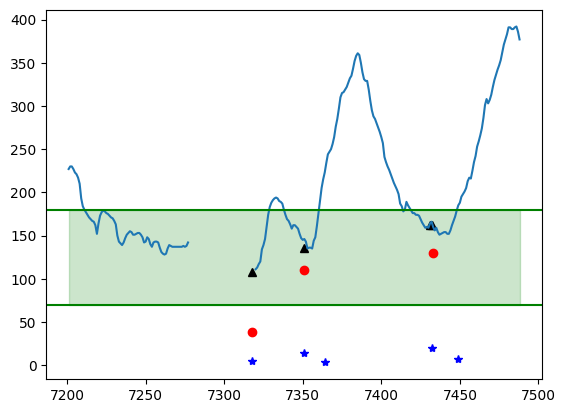

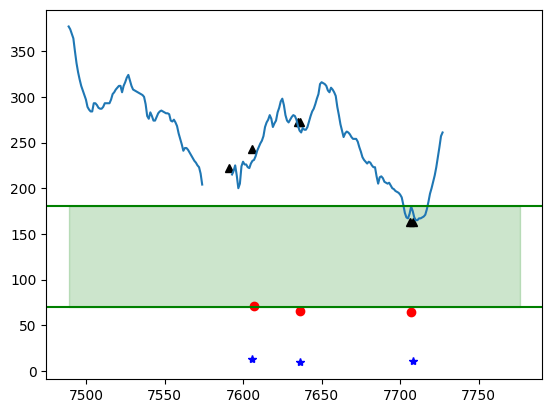

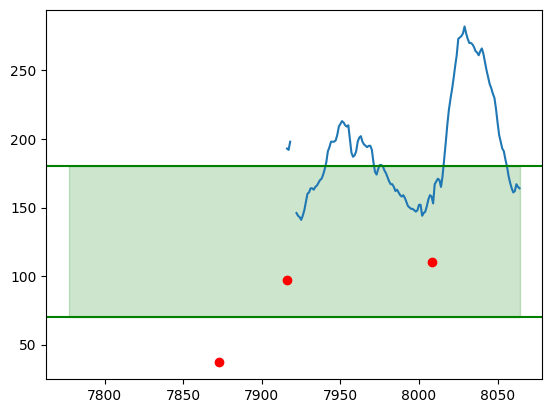

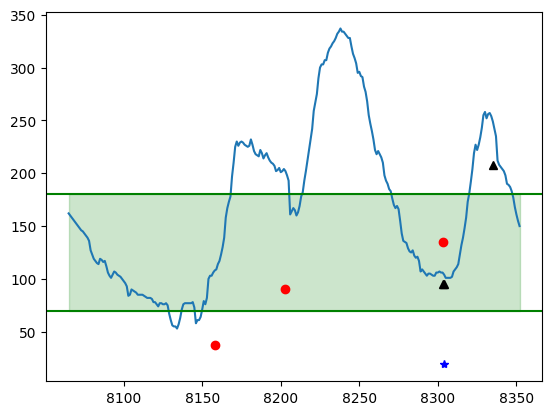

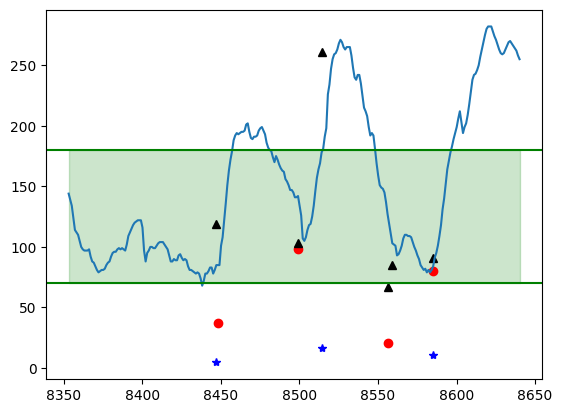

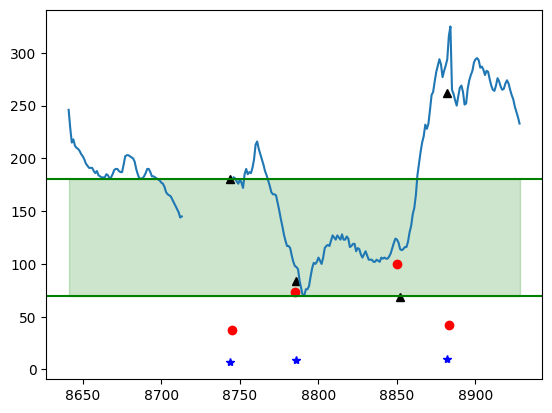

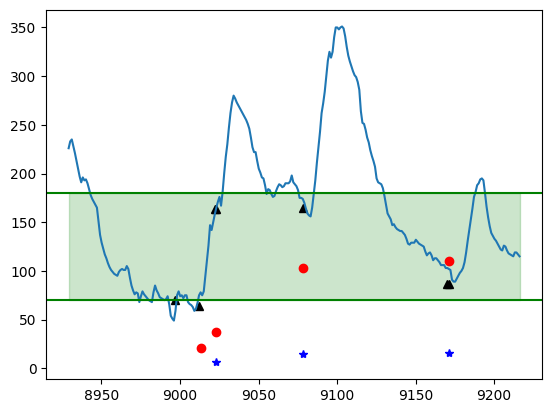

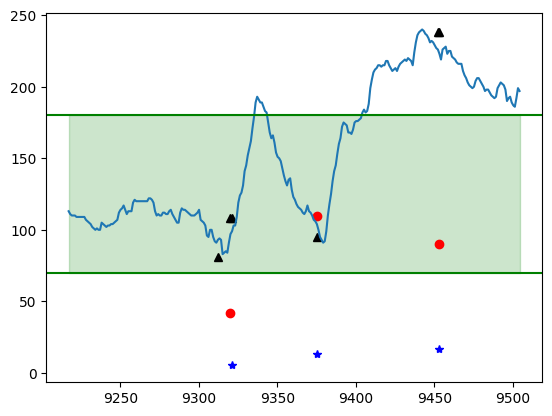

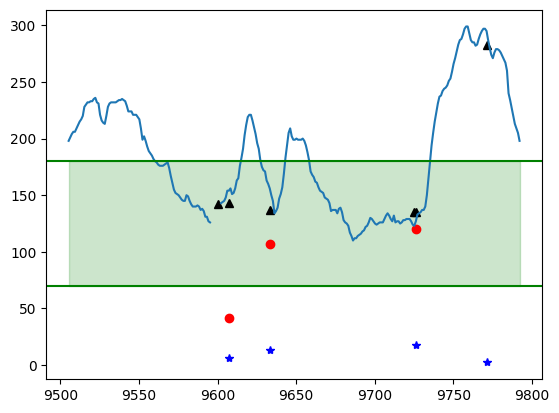

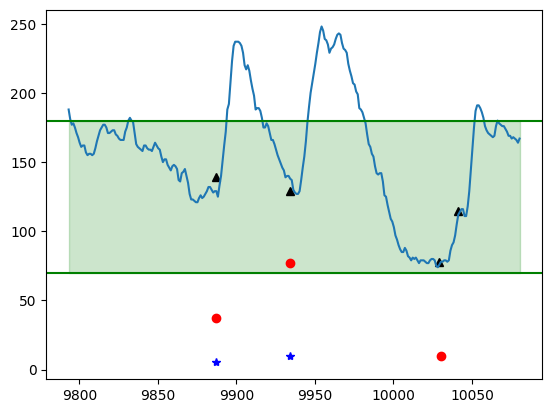

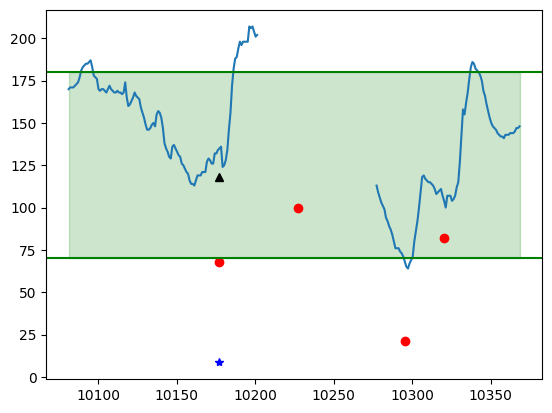

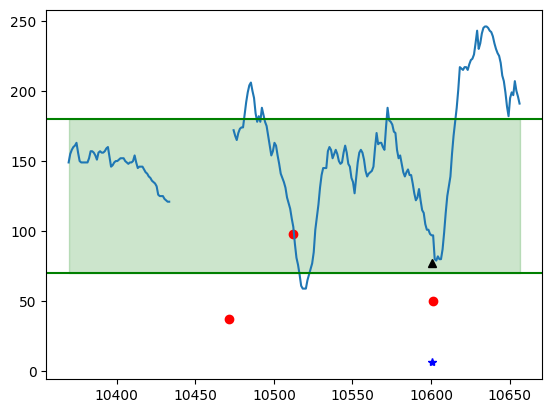

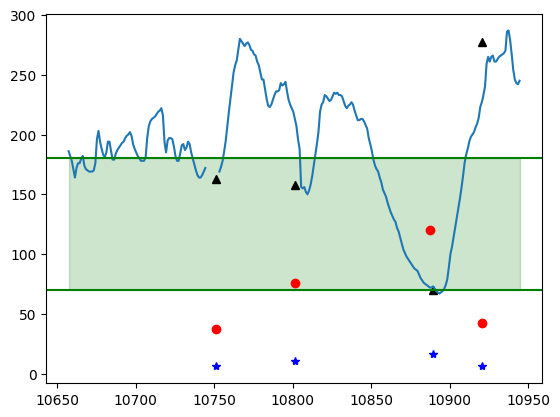

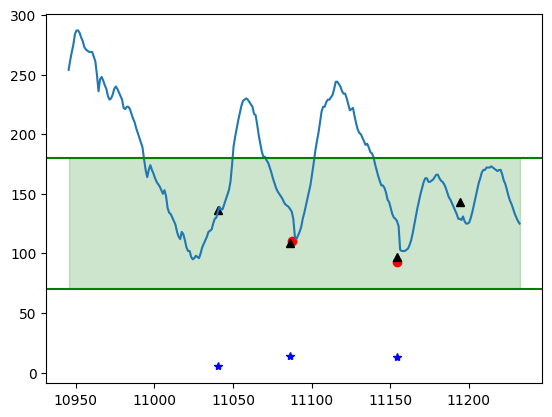

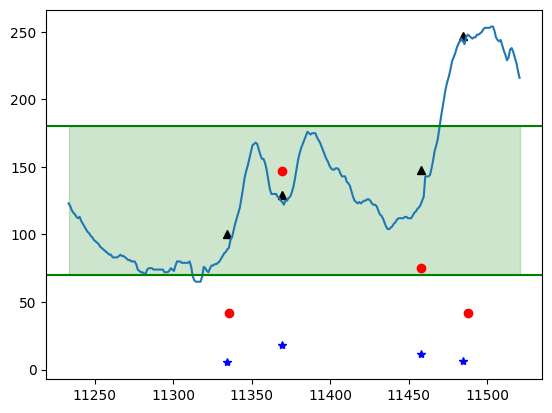

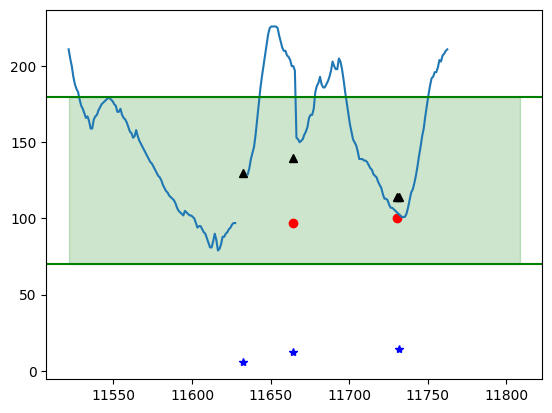

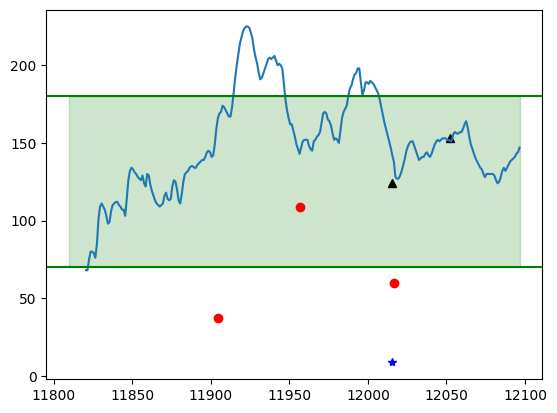

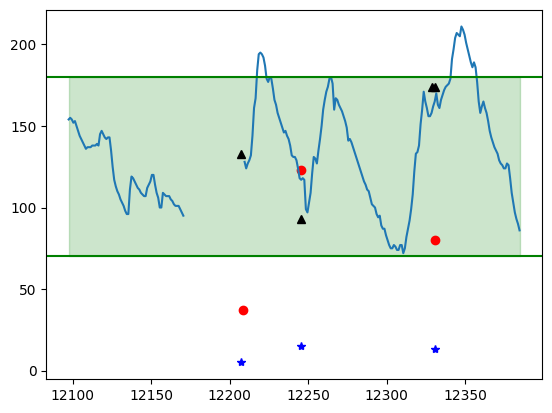

In [12]:
# Load the dataset
file = "../../data/Ohio2020_processed/train/544-ws-training_processed.csv"

df = pd.read_csv(file)
print(df.columns.values)
# Start time samples from zero
df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]

filtered_df_carbs = df[df["carbInput"].notnull()]
filtered_df_finger = df[df["finger"].notnull()]
days = len(df) // 288
for i in range(days):
    plt.figure()
    start = i*288
    end = (i+1)*288
    # plt.figure()
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["carbInput"][start:end], "ro", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["finger"][start:end], "k^", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["bolus"][start:end], "b*", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["cbg"][start:end], label="CarbInput")
    plt.axhline(y=70, color='g', linestyle='-')
    plt.axhline(y=180, color='g', linestyle='-')
    plt.fill_between(df["5minute_intervals_timestamp"][start:end], 70, 180, color='g', alpha=0.2)

In [4]:
df = df.drop("5minute_intervals_timestamp", axis=1)

In [5]:
df.isna().sum()

missing_cbg        0
cbg              465
finger         12549
basal             49
hr               391
gsr              440
carbInput      12885
bolus          12924
dtype: int64

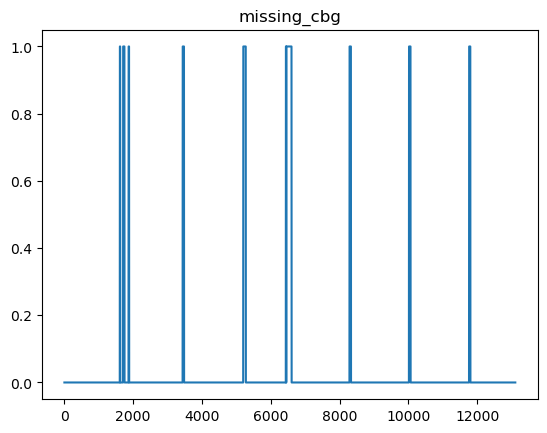

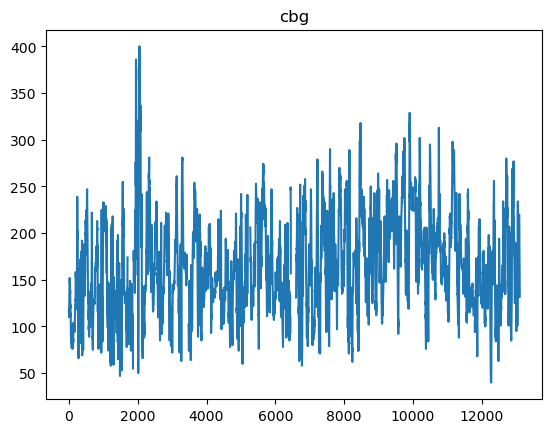

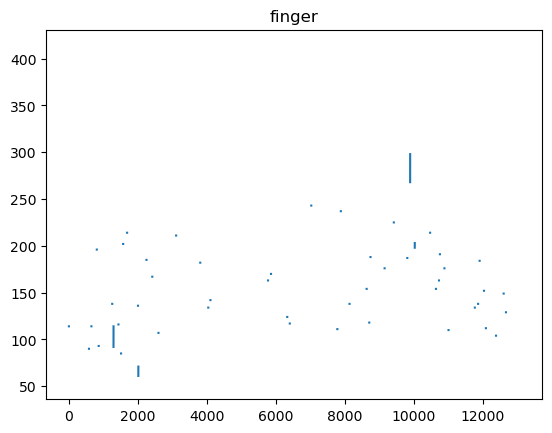

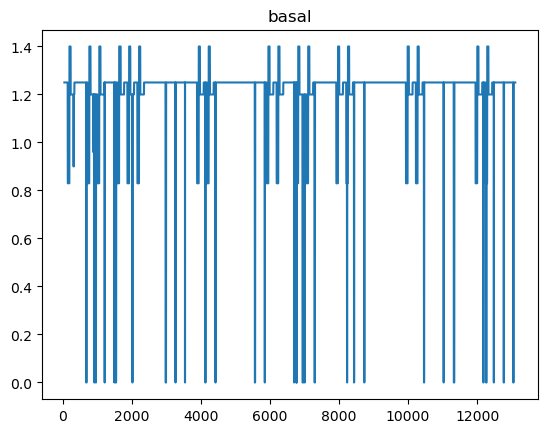

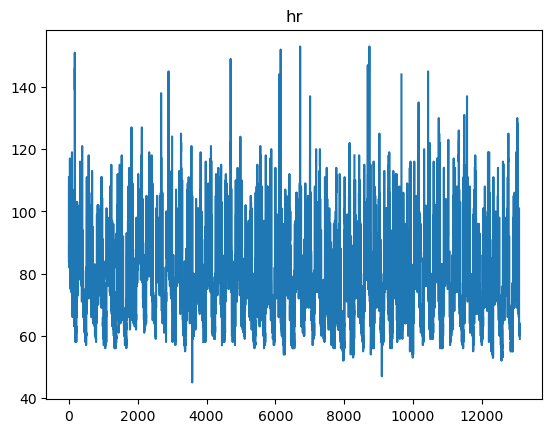

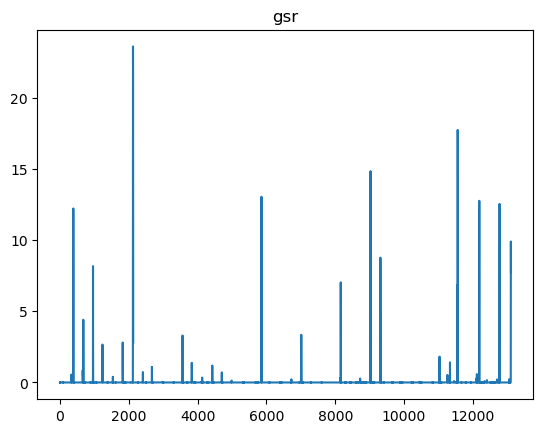

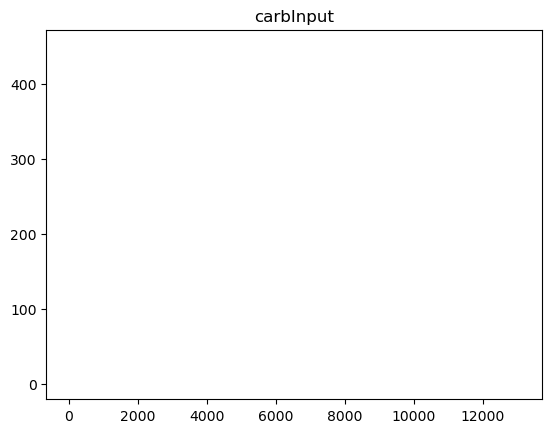

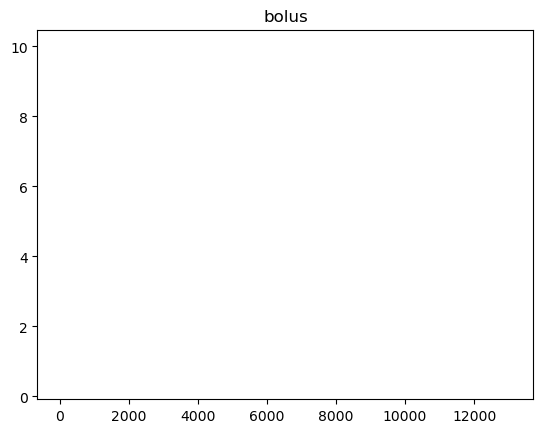

In [6]:

for column in df.columns.values:
    plt.figure()
    plt.plot(df[column])
    plt.title(f"{column}")

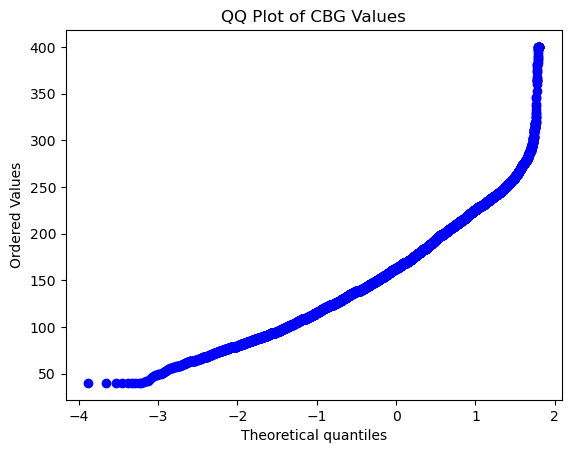

In [ ]:
import scipy.stats as stats

# QQ plot of cbg values
stats.probplot(df['cbg'], dist="norm", plot=plt)
plt.title('QQ Plot of CBG Values')
plt.show()
# Since the CBG values are not normally distributed, the MinMaxScaler is used instead of the StandardScaler.

In [8]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(df['cbg'].dropna())  # Drop NaNs to avoid issues
print('Shapiro-Wilk Test:')
print(f'Statistic={stat:.3f}, p-value={p_value:.3f}')
if p_value > 0.05:
    print("Data is likely normal.")
else:
    print("Data is likely not normal.")

Shapiro-Wilk Test:
Statistic=0.982, p-value=0.000
Data is likely not normal.


/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12640.
  res = hypotest_fun_out(*samples, **kwds)


Text(0.5, 1.0, 'Autocorrelation of current and previous time sample.')

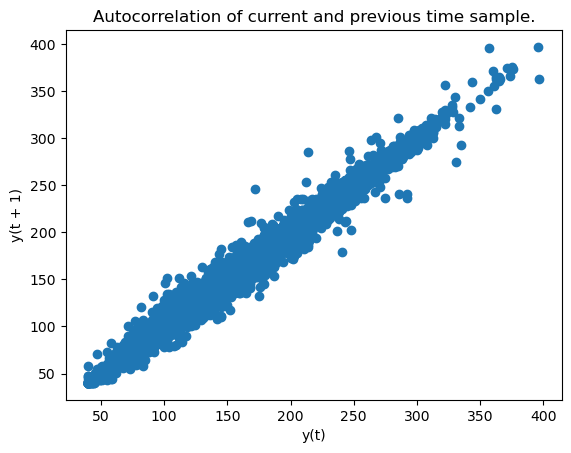

In [10]:
series = df.cbg
pd.plotting.lag_plot(series, )
plt.title("Autocorrelation of current and previous time sample.")

         t-1      t+1
t-1  1.00000  0.99338
t+1  0.99338  1.00000


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

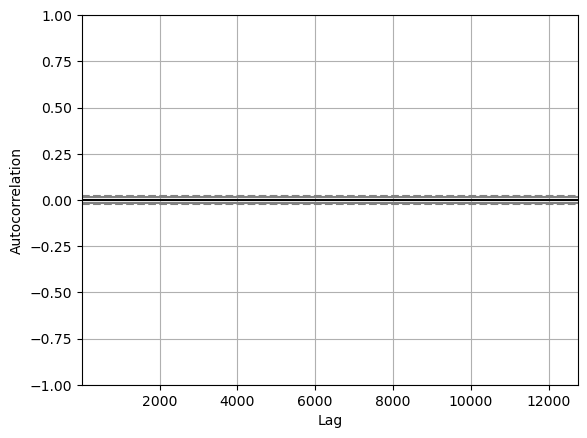

In [11]:
series = df.cbg
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)
# Very high correlation between current and previous time sample. corr = 0.995
pd.plotting.autocorrelation_plot(series=series)

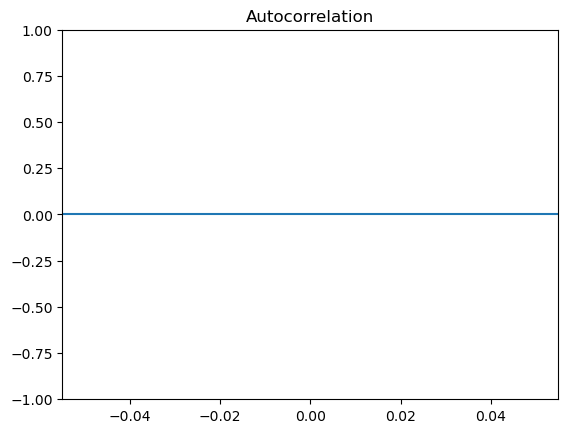

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
series = df.cbg
plot_acf(series, lags=1)
plt.show()

In [13]:
def append_if_in_range(subset_a, subset_b, distance=6, bolus = False):
    ranges = [(idx - distance, idx + distance) for idx in subset_a.index]  # Create ranges around each index in A
    
    # Function to check if the index is within any range
    def in_any_range(idx):
        return any(start <= idx <= end for start, end in ranges)
    
    # Create a new dataframe for valid entries in subset B
    valid_b = subset_b[subset_b.index.to_series().apply(in_any_range)]
    
    # Append the valid rows from subset B to subset A
    temp = pd.concat([subset_a, valid_b], join="outer").sort_index().drop_duplicates()

    # List of index values where we want to split the DataFrame
    split_indices = valid_b.index.to_list() # The DataFrame will be split at index 3 and 6
    # Initialize the starting point of the split
    start_idx = subset_a.index.to_list()[0]
    # Initialize an empty list to hold the sub-DataFrames
    sub_dfs = []

    # Iterate through the split indices and slice the DataFrame
    for idx in split_indices:
        sub_dfs.append(temp.loc[start_idx:idx-1].copy())
        start_idx = idx

    # Append the last section of the DataFrame (from last split point to end)
    sub_dfs.append(temp.loc[start_idx:].copy())

    # Show the resulting sub-DataFrames
    if not bolus:
        for sub_df in sub_dfs:
            values = sub_df.index.to_list()
            sub_df["minAfterMeal"] = [(x-values[0])*5 for x in values]
    else:
        for sub_df in sub_dfs:
            values = sub_df.index.to_list()
            sub_df["minAfterBolus"] = [(x-values[0])*5 for x in values]

    result = pd.concat(sub_dfs)
    
    return result

In [14]:
# List of DataFrame indexes 
carbIntake = []

# Filter for carb intake, where carb intake is not null
filtered_df_carbs = df[df["carbInput"].notnull()]
filtered_df_bolus= df[df["bolus"].notnull()]
filtered_df_hr = df[df["hr"].notnull()]
sampling_time = 5
nbr_of_mins = 10
nbr_of_hours = 3
nbr_of_lags = 3
nbr_of_time_steps =int(nbr_of_mins/sampling_time)
nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

for index, row in filtered_df_carbs.iterrows():
    filtered_df_carbs = filtered_df_carbs.drop(filtered_df_carbs.index.to_list()[0])
    carbIntakePerIndex = []
    for i in range(nbr_of_total_samples):
        try:
            carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
        except:
            print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
            break
    # Create the Data Frame
    carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
        
    # Include all indeces of further carb intakes between the indeces
    carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_carbs)
    # carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_bolus)
    

    # Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
    lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag*nbr_of_time_steps).bfill() for lag in range(1, nbr_of_lags)}
    carbIntakePerIndex_df = carbIntakePerIndex_df.assign(**lagged_features)
    if carbIntakePerIndex_df["missing_cbg"].any() > 0:
        continue

    carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).set_index((x-carbIntakePerIndex_df.index.tolist()[0])*5 for x in carbIntakePerIndex_df.index.tolist()))

    


KeyError: "['5minute_intervals_timestamp'] not found in axis"

In [ ]:
## Create Data Set
def createDataSet(file):
    df = pd.read_csv(file)
    # Start time samples from zero
    df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]
    # List of DataFrame indexes 
    carbIntake = []

    # Filter for carb intake, where carb intake is not null
    filtered_df_carbs = df[df["carbInput"].notnull()]
    filtered_df_bolus= df[df["bolus"].notnull()]
    filtered_df_hr = df[df["hr"].notnull()]
    sampling_time = 5
    nbr_of_mins = 10
    nbr_of_hours = 3
    nbr_of_lags = 3
    nbr_of_time_steps =int(nbr_of_mins/sampling_time)
    nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
    nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

    def append_if_in_range(subset_a, subset_b, distance=6, bolus = False):
        ranges = [(idx - distance, idx + distance) for idx in subset_a.index]  # Create ranges around each index in A
    
        # Function to check if the index is within any range
        def in_any_range(idx):
            return any(start <= idx <= end for start, end in ranges)
        
        # Create a new dataframe for valid entries in subset B
        valid_b = subset_b[subset_b.index.to_series().apply(in_any_range)]
        
        # Append the valid rows from subset B to subset A
        temp = pd.concat([subset_a, valid_b], join="outer").sort_index().drop_duplicates()

        # List of index values where we want to split the DataFrame
        split_indices = valid_b.index.to_list() # The DataFrame will be split at index 3 and 6
        # Initialize the starting point of the split
        start_idx = subset_a.index.to_list()[0]
        # Initialize an empty list to hold the sub-DataFrames
        sub_dfs = []

        # Iterate through the split indices and slice the DataFrame
        for idx in split_indices:
            sub_dfs.append(temp.loc[start_idx:idx-1].copy())
            start_idx = idx

        # Append the last section of the DataFrame (from last split point to end)
        sub_dfs.append(temp.loc[start_idx:].copy())

        # Show the resulting sub-DataFrames
        if not bolus:
            for sub_df in sub_dfs:
                values = sub_df.index.to_list()
                sub_df["minAfterMeal"] = [(x-values[0])*5 for x in values]
        else:
            for sub_df in sub_dfs:
                values = sub_df.index.to_list()
                sub_df["minAfterBolus"] = [(x-values[0])*5 for x in values]

        result = pd.concat(sub_dfs)
        
        return result

    for index, row in filtered_df_carbs.iterrows():
        filtered_df_carbs = filtered_df_carbs.drop(filtered_df_carbs.index.to_list()[0])
        carbIntakePerIndex = []
        for i in range(nbr_of_total_samples):
            try:
                carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
            except:
                print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
                break
        # Create the Data Frame
        carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
            
        # Include all indeces of further carb intakes between the indeces
        carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_carbs)
        # carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_bolus)
        

        # Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
        lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag*nbr_of_time_steps).bfill() for lag in range(1, nbr_of_lags)}
        carbIntakePerIndex_df = carbIntakePerIndex_df.assign(**lagged_features)
        if carbIntakePerIndex_df["missing_cbg"].any() > 0:
            continue

        carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).set_index((x-carbIntakePerIndex_df.index.tolist()[0])*5 for x in carbIntakePerIndex_df.index.tolist()))
    return carbIntake
    

    

In [ ]:
test = createDataSet("../../data/Ohio2020_processed/train/540-ws-training_processed.csv")
test[0]

In [ ]:
carbIntake[0]

In [ ]:
X_train, X_test = train_test_split(carbIntake, test_size=0.33, random_state=42)

In [ ]:
def train_model(data, model, train = True):
    # Random seed from reproducibility
    # random.Random(42).shuffle(carbIntake)
    # Perform train-test split on the combined DataFrame
    

    # Data is scaled using MinMaxScaler to ensure that all features are within the same range, typically between 0 and 1.
    scaler = MinMaxScaler()

    X_train = data.drop(["cbg"], axis=1)
    y_train = data["cbg"]

    carbInput = data[data["carbInput"] > 0]

    X_train_scaled = scaler.fit_transform(X_train)
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # carbInput = train[train["carbInput"] > 0]
    carbInput_scaled = scaler.fit_transform(carbInput["carbInput"].values.reshape(-1, 1))

    # Linear Regression
    # Train the linear regression model on the scaled data
    if train:
        model.fit(X_train_scaled, y_train_scaled)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)

    # SVR model
    # model = SVR(kernel='rbf', gamma=0.3, C=10, epsilon=0.4)

    # # Fit the model
    # model.fit(X_train, y_train)
    # y_train_pred = model.predict(X_train).reshape(-1,1)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(X_train.index, y_train_scaled, label="Ground Truth")
    axs[0].plot(X_train.index,y_train_pred, label="Prediction")
    axs[0].plot(carbInput.index, carbInput_scaled, "ro")
    axs[1].bar(X_train.columns.values, model.coef_[0])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    axs[0].legend()

    return  model.coef_[0]
    
    # plt.legend()

In [ ]:
coef = []
model = SVR(kernel='linear')
for data in X_train:
    plt.figure()
    coef.append(train_model(data, model))


In [ ]:
averageCoef = 0
for x in coef:
    averageCoef += x

averageCoef / len(coef)

In [ ]:
ensemble_model = LinearRegression()
ensemble_model.coef_ = averageCoef
for data in X_test:
    plt.figure()
    train_model(data, model, train=False)
    

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

## Create Data Set
def createDataSet(file):
    df = pd.read_csv(file)
    # Start time samples from zero
    df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]
    # List of DataFrame indexes 
    carbIntake = []

    # Filter for carb intake, where carb intake is not null
    filtered_df_carbs = df[df["carbInput"].notnull()]
    filtered_df_bolus= df[df["bolus"].notnull()]
    filtered_df_hr = df[df["hr"].notnull()]
    sampling_time = 5
    nbr_of_mins = 5
    nbr_of_hours = 2
    nbr_of_lags = 3
    nbr_of_time_steps =int(nbr_of_mins/sampling_time)
    nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
    nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

    def append_if_in_range(subset_a, subset_b, distance=6, bolus = False):
        ranges = [(idx - distance, idx + distance) for idx in subset_a.index]  # Create ranges around each index in A
    
        # Function to check if the index is within any range
        def in_any_range(idx):
            return any(start <= idx <= end for start, end in ranges)
        
        # Create a new dataframe for valid entries in subset B
        valid_b = subset_b[subset_b.index.to_series().apply(in_any_range)]
        
        # Append the valid rows from subset B to subset A
        temp = pd.concat([subset_a, valid_b], join="outer").sort_index().drop_duplicates()

        # List of index values where we want to split the DataFrame
        split_indices = valid_b.index.to_list() # The DataFrame will be split at index 3 and 6
        # Initialize the starting point of the split
        start_idx = subset_a.index.to_list()[0]
        # Initialize an empty list to hold the sub-DataFrames
        sub_dfs = []

        # Iterate through the split indices and slice the DataFrame
        for idx in split_indices:
            sub_dfs.append(temp.loc[start_idx:idx-1].copy())
            start_idx = idx

        # Append the last section of the DataFrame (from last split point to end)
        sub_dfs.append(temp.loc[start_idx:].copy())

        # Show the resulting sub-DataFrames
        if not bolus:
            for sub_df in sub_dfs:
                values = sub_df.index.to_list()
                sub_df["minAfterMeal"] = [(x-values[0])*5 for x in values]
        else:
            for sub_df in sub_dfs:
                values = sub_df.index.to_list()
                sub_df["minAfterBolus"] = [(x-values[0])*5 for x in values]

        result = pd.concat(sub_dfs)
        
        return result

    for index, row in filtered_df_carbs.iterrows():
        filtered_df_carbs = filtered_df_carbs.drop(filtered_df_carbs.index.to_list()[0])
        carbIntakePerIndex = []
        for i in range(nbr_of_total_samples):
            try:
                carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
            except:
                print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
                break
        # Create the Data Frame
        carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
            
        # Include all indeces of further carb intakes between the indeces
        carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_carbs)
        # carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_bolus)
        

        # Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
        lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag*nbr_of_time_steps).bfill() for lag in range(1, nbr_of_lags)}
        carbIntakePerIndex_df = carbIntakePerIndex_df.assign(**lagged_features)
        if carbIntakePerIndex_df["missing_cbg"].any() > 0:
            continue

        carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).set_index((x-carbIntakePerIndex_df.index.tolist()[0])*5 for x in carbIntakePerIndex_df.index.tolist()))
    return carbIntake
    

if __name__ == "__main__":
    # Load the dataset
    file = "data/Ohio2020_processed/train/540-ws-training_processed.csv"
    
    data = createDataSet(file)
    display(data[0])

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

## Create Data Set
def createDataSet(file):
    df = pd.read_csv(file)
    # Start time samples from zero
    df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]
    # List of DataFrame indexes 
    carbIntake = []

    # Filter for carb intake, where carb intake is not null
    filtered_df_carbs = df[df["carbInput"].notnull()]
    filtered_df_bolus= df[df["bolus"].notnull()]
    filtered_df_hr = df[df["hr"].notnull()]
    sampling_time = 5
    nbr_of_mins = 5
    nbr_of_hours = 2
    nbr_of_lags = 3
    nbr_of_time_steps =int(nbr_of_mins/sampling_time)
    nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
    nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

    def append_if_in_range(subset_a, subset_b, distance=6, bolus = False):
        ranges = [(idx - distance, idx + distance) for idx in subset_a.index]  # Create ranges around each index in A
    
        # Function to check if the index is within any range
        def in_any_range(idx):
            return any(start <= idx <= end for start, end in ranges)
        
        # Create a new dataframe for valid entries in subset B
        valid_b = subset_b[subset_b.index.to_series().apply(in_any_range)]
        
        # Append the valid rows from subset B to subset A
        temp = pd.concat([subset_a, valid_b], join="outer").sort_index().drop_duplicates()

        # List of index values where we want to split the DataFrame
        split_indices = valid_b.index.to_list() # The DataFrame will be split at index 3 and 6
        # Initialize the starting point of the split
        start_idx = subset_a.index.to_list()[0]
        # Initialize an empty list to hold the sub-DataFrames
        sub_dfs = []

        # Iterate through the split indices and slice the DataFrame
        for idx in split_indices:
            sub_dfs.append(temp.loc[start_idx:idx-1].copy())
            start_idx = idx

        # Append the last section of the DataFrame (from last split point to end)
        sub_dfs.append(temp.loc[start_idx:].copy())

        # Show the resulting sub-DataFrames
        if not bolus:
            for sub_df in sub_dfs:
                values = sub_df.index.to_list()
                sub_df["minAfterMeal"] = [(x-values[0])*5 for x in values]
        else:
            for sub_df in sub_dfs:
                values = sub_df.index.to_list()
                sub_df["minAfterBolus"] = [(x-values[0])*5 for x in values]

        result = pd.concat(sub_dfs)
        
        return result

    for index, row in filtered_df_carbs.iterrows():
        filtered_df_carbs = filtered_df_carbs.drop(filtered_df_carbs.index.to_list()[0])
        carbIntakePerIndex = []
        for i in range(nbr_of_total_samples):
            try:
                carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
            except:
                print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
                break
        # Create the Data Frame
        carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
            
        # Include all indeces of further carb intakes between the indeces
        carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_carbs)
        # carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_bolus)
        

        # Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
        lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag*nbr_of_time_steps).bfill() for lag in range(1, nbr_of_lags)}
        carbIntakePerIndex_df = carbIntakePerIndex_df.assign(**lagged_features)
        if carbIntakePerIndex_df["missing_cbg"].any() > 0:
            continue

        carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).set_index((x-carbIntakePerIndex_df.index.tolist()[0])*5 for x in carbIntakePerIndex_df.index.tolist()))
    

In [ ]:
def createDataSet(file=file):
    # Load the dataset
    df = pd.read_csv(file)
    df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]
    # Scale the whole dataset
    # Data is scaled using MinMaxScaler to ensure that all features are within the same range, typically between 0 and 1.
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    display(df)


    # List of DataFrame indexes 
    carbIntake = []

    # Filter for carb intake, where carb intake is not null
    filtered_df_carbs = df[df["carbInput"].notnull()]
    filtered_df_bolus = df[df["bolus"].notnull()]

    
    # Variables used for selecting the correct timestamps.
    sampling_time = 5
    nbr_of_mins = 5
    nbr_of_hours = 2
    nbr_of_lags = 3
    nbr_of_time_steps =int(nbr_of_mins/sampling_time)
    nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
    nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

    for index, row in filtered_df_carbs.iterrows():
        # filtered_df_carbs = filtered_df_carbs.drop(filtered_df_carbs.index.to_list()[0])
        carbIntakePerIndex = []
        for i in range(nbr_of_total_samples):
            try:
                carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
            except:
                print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
                break
        # Create the Data Frame
        carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
        # Creating minAfterMeal and mealSize
        values = carbIntakePerIndex_df.index.to_list()
        carbIntakePerIndex_df["minAfterMeal"] = [(x-values[0])*5 for x in values]
        carbIntakePerIndex_df["mealSize"] = carbIntakePerIndex_df["carbInput"].iloc[0]

        # Do the same with bolus values
        # Find the first non-zero row
        non_zero_index = carbIntakePerIndex_df[carbIntakePerIndex_df["bolus"].notna()].index.min()
        # Set all rows after the first non-zero row to that value
        if pd.notna(non_zero_index):  # Check if there is a non-zero value in the column
            carbIntakePerIndex_df.loc[non_zero_index+1:, "bolusShot"] = carbIntakePerIndex_df.loc[non_zero_index, 'bolus']

        # Iterate over each row
        for index, row in carbIntakePerIndex_df.iterrows():
            # Check if the current value is non-zero and non-NaN, update `current_value`
            if pd.notna(row['carbInput']):
                current_value = row['carbInput']
            # Set the value in the row to the current non-zero, non-NaN `current_value`
            carbIntakePerIndex_df.at[index, 'mealSize'] = current_value


        # Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
        lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag*nbr_of_time_steps).bfill() for lag in range(1, nbr_of_lags)}
        carbIntakePerIndex_df = carbIntakePerIndex_df.assign(**lagged_features)
        if carbIntakePerIndex_df["missing_cbg"].any() > 0:
            continue

        carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).set_index((x-carbIntakePerIndex_df.index.tolist()[0])*5 for x in carbIntakePerIndex_df.index.tolist()))
    return carbIntake, scaler



In [ ]:
file = "../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
data, scaler = createDataSet(file)
print(len(data))
for i in range(len(data)):
    display(data[i])